<a href="https://colab.research.google.com/github/suleymanerim1/Data-Analysis/blob/main/Restricted%20Boltzman%20Machine%2C%20Deep%20Belief%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cognition & Computation - Lab 1

To start with, let's download some scripts from a GitHub repository that implement a DBN in PyTorch.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


Then, let's download the MNIST dataset. We download both the train and test datasets (we will use the test dataset later on).

In [5]:
%%capture
# train true , I want to use as train set
# train false, I want to use as test set
mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize((0.1307,), (0.3081,))]  # here we use the mean and std computed on the MNIST training set
                                         ))

mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor(),
                                         tv.transforms.Normalize((0.1307,), (0.3081,))]
                                ))

In [6]:
mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

The number shown is the number: 2


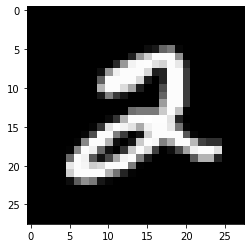

In [7]:
idx = 5
img = mnist_train.data[idx]
print("The number shown is the number: {}".format(mnist_train.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [8]:
mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)

In [9]:
mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

## Training a DBN
Quick recall from the course theory: 
- a Deep Belief Network is made by a stack of Restricted Boltzmann Machines, which are energy-based models;
- they are *unsupervised* deep learning architectures, whose goal is to learn the probability distribution that could have generated the training data (maximum-likelihood);
- this means they can be used to run both *forward* (bottom-up) and *backward* (top-down) passes through the architecture, to compute either hidden representations ("inference" over latent variables) or to generate prototypical examples of a specific class;
- they are trained using an algorithm called *contrastive divergence*, whose goal is to reduce the difference between the learned probability distribution and the true (empirical) one.

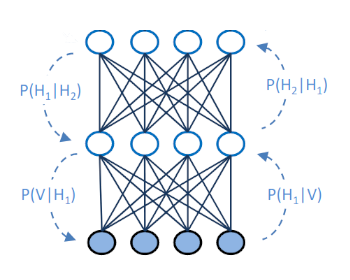

In [59]:
dbn_mnist = DBN(visible_units=28*28,
                hidden_units=[500, 500, 2000], # neurons
                k=1,  #1 step constractive divergence
                learning_rate=0.2,
                learning_rate_decay=True, # decay
                initial_momentum=0.5,  # momentum to speed up convergence of gradient descen
                final_momentum=0.95,
                weight_decay=0.0001, 
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Let's train the network:

In [60]:
num_epochs = 50
batch_size = 125

dbn_mnist.train_static(
    mnist_train.data,
    mnist_train.targets,
    num_epochs,
    batch_size
)

# avg reconstruction error
# mean gradient
#std: standard deviation

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1522     |0.0583       |67.4252   |1.7537     |
|20    |1.0588     |0.0492       |32.8343   |0.8273     |
|30    |1.0321     |0.0470       |21.9053   |0.5447     |
|40    |1.0148     |0.0455       |16.4133   |0.3944     |
|50    |1.0051     |0.0455       |13.0410   |0.3255     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8583     |0.0709       |48.2733   |1.3378     |
|20    |1.5721     |0.0529       |24.1440   |0.7271     |
|30    |1.4973     |0.0530       |15.9827   |0.3431     |
|40    |1.4637     |0.0498       |12.1831   |0.2759     |
|50    |1.4450     |0.0502       |9.8127   |0.2428     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2187     |0.0487       |53.8468   |1.4462     |
|20    |1.0975     |0.0421       |26.1401   |0.7202     |
|30  

## Visualizing receptive fields

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the MNIST images we used for training. In this way, we will see which parts of an image trigger the unit associated with a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy. Finally, the values in different weigths could have different ranges, so we will use a `MinMaxScaler` from Scikit-Learn to make a meaningful comparison among the visualizations of different receptive fields.

In [61]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

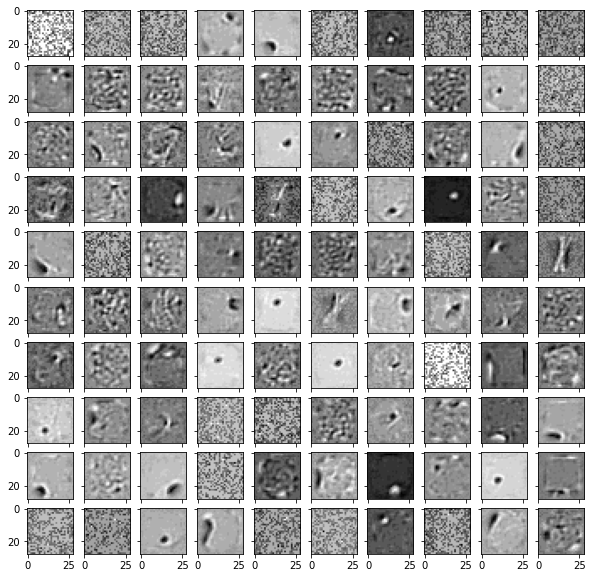

In [62]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as MNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

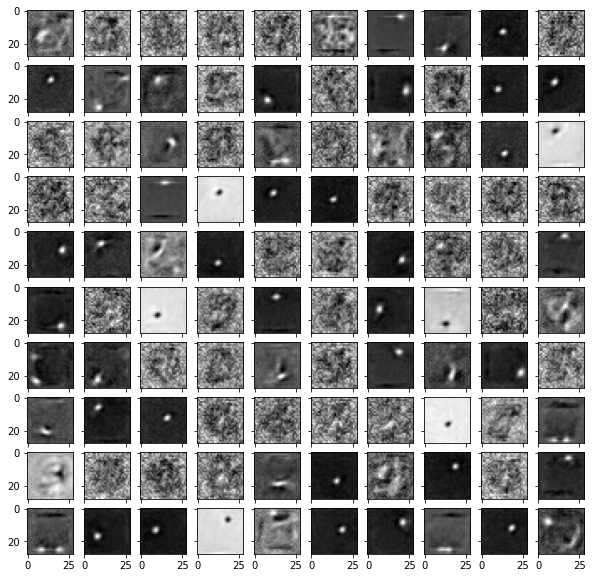

In [63]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

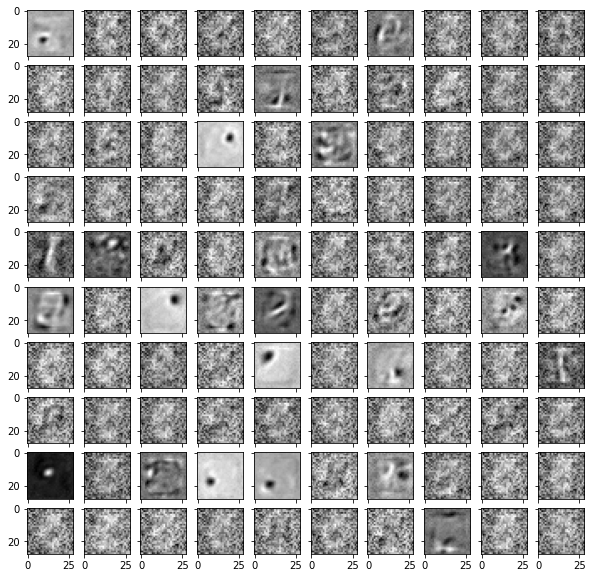

In [64]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_mnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [65]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

Of course, the representations computed using the second layer are computed using the ones from the first layer:

In [66]:
hidden_repr_layer_1 = get_kth_layer_repr(mnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [67]:
def get_mask(label):  # we use this function to filter by class
  labels = mnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [68]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [69]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

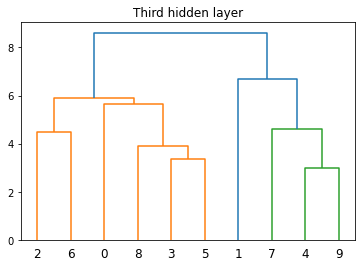

In [70]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")
# DBM considers digit 4-9 are similar to each other
# or 5-8 and 3 resembles by properties, they are similar

## Linear read-out

Now we make a linear readout of the representations computed by the DBN at each layer. This means that we will use the representations to classify the original images with a simple linear classifier, as a way to assess how much information is contained in each hidden representatation. 
Let's first define the class for the linear model:

In [71]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)  # linear classifier with 10 output classes

  def forward(self, x):
    return self.linear(x)

Then, we can instantiate a linear model for each layer of the DBN:

In [72]:
layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Then, we train the linear classifiers on the hidden representations from each layer using the actual labels of the MNIST dataset as targets:

In [73]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = mnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [74]:
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/1500, loss = 2.3672
epoch : 101/1500, loss = 0.7019
epoch : 201/1500, loss = 0.5212
epoch : 301/1500, loss = 0.4491
epoch : 401/1500, loss = 0.4084
epoch : 501/1500, loss = 0.3814
epoch : 601/1500, loss = 0.3619
epoch : 701/1500, loss = 0.3468
epoch : 801/1500, loss = 0.3347
epoch : 901/1500, loss = 0.3247
epoch : 1001/1500, loss = 0.3162
epoch : 1101/1500, loss = 0.3089
epoch : 1201/1500, loss = 0.3024
epoch : 1301/1500, loss = 0.2967
epoch : 1401/1500, loss = 0.2916


In [75]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/1500, loss = 2.2729
epoch : 101/1500, loss = 0.7493
epoch : 201/1500, loss = 0.5610
epoch : 301/1500, loss = 0.4848
epoch : 401/1500, loss = 0.4417
epoch : 501/1500, loss = 0.4131
epoch : 601/1500, loss = 0.3924
epoch : 701/1500, loss = 0.3764
epoch : 801/1500, loss = 0.3636
epoch : 901/1500, loss = 0.3531
epoch : 1001/1500, loss = 0.3441
epoch : 1101/1500, loss = 0.3364
epoch : 1201/1500, loss = 0.3296
epoch : 1301/1500, loss = 0.3236
epoch : 1401/1500, loss = 0.3183


In [76]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 2.2932
epoch : 101/1500, loss = 0.6473
epoch : 201/1500, loss = 0.4814
epoch : 301/1500, loss = 0.4151
epoch : 401/1500, loss = 0.3775
epoch : 501/1500, loss = 0.3525
epoch : 601/1500, loss = 0.3343
epoch : 701/1500, loss = 0.3203
epoch : 801/1500, loss = 0.3089
epoch : 901/1500, loss = 0.2995
epoch : 1001/1500, loss = 0.2915
epoch : 1101/1500, loss = 0.2846
epoch : 1201/1500, loss = 0.2785
epoch : 1301/1500, loss = 0.2731
epoch : 1401/1500, loss = 0.2682


Let's now build the representation for the test set we kept apart at the beginning, and use them to evaluate the trained linear readouts:

In [77]:
hidden_repr_layer_1_test = get_kth_layer_repr(mnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [78]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

Finally, let's compute the accuracy scores:

In [79]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [80]:
compute_accuracy(predictions_test1, mnist_test.targets)

0.9257999658584595

In [81]:
compute_accuracy(predictions_test2, mnist_test.targets)

0.9188999533653259

In [82]:
compute_accuracy(predictions_test3, mnist_test.targets)

0.9307000041007996

## Reference papers
- [G. Hinton - A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [G. Hinton, R. Salakhutdinov - Reducing the Dimensionality of Data with Neural Networks](https://www.science.org/doi/10.1126/science.1127647)
- [Testolin et al. - Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)
- [A. Fischer, C. Igel - Training restricted Boltzmann machines: An introduction](https://www.sciencedirect.com/science/article/pii/S0031320313002495)

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)